In [ ]:
라이브러리 임포트 및 데이터 로드

In [13]:
import numpy as np
# keras 라이브러리는 아나콘다에 포함되지 않아서 설치 필요(pip install keras)
from keras.datasets import mnist # mnist 데이터 임포트
import tensorflow as tf # 텐서플로우 임포트

(X_train, y_train), (X_test, y_test) = mnist.load_data()

np.random.seed(0) # 랜덤값을 위한 시드
train_indices = np.random.choice(60000, 50000, replace=False)
valid_indices = [i for i in range(60000) if i not in train_indices]
X_valid, y_valid = X_train[valid_indices,:,:], y_train[valid_indices]
X_train, y_train = X_train[train_indices,:,:], y_train[train_indices]

print(X_train.shape, X_valid.shape, X_test.shape)
# (50000, 28, 28) (10000, 28, 28) (10000, 28, 28)

(50000, 28, 28) (10000, 28, 28) (10000, 28, 28)


In [14]:
image_size = 28
num_labels = 10
dims = image_size * image_size

def reformat(dataset, labels):
    dataset = dataset.reshape((-1, dims)).astype(np.float32) # 입력 데이터 전개
    # one hot encoding: 1→[0, 1, 0 ...], 2 → [0, 0, 1 ...]
    labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
    return dataset, labels

X_train, y_train = reformat(X_train, y_train)
X_valid, y_valid = reformat(X_valid, y_valid)
X_test, y_test = reformat(X_test, y_test)
print('Training set', X_train.shape) # Training set (50000, 784)
print('Validation set', X_valid.shape) # Validation set (10000, 784)
print('Test set', X_test.shape) # Test set (10000, 784)

Training set (50000, 784)
Validation set (10000, 784)
Test set (10000, 784)


In [15]:
batch_size = 256
num_hidden_units = 1024
lambda1, lambda2 = 0.1, 0.1

graph = tf.Graph()
with graph.as_default():
    # 훈련을 위한 데이터 - 실행시간 값 제공 위해 placeholder 사용
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, dims))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(X_valid)
    tf_test_dataset = tf.constant(X_test)
    
    # 변수들 지정
    weights1 = tf.Variable(tf.truncated_normal([dims, num_hidden_units]))
    biases1 = tf.Variable(tf.zeros([num_hidden_units]))
    
    # 행렬 내적 연산과 bias 더해 입력을 은닉층으로 연결, relu 함수로 출력
    layer_1_outputs = tf.nn.relu(tf.matmul(tf_train_dataset, weights1)+ biases1)
    weights2 = tf.Variable(tf.truncated_normal([num_hidden_units, num_labels]))
    biases2 = tf.Variable(tf.zeros([num_labels]))
    
    # 학습 계산
    logits = tf.matmul(layer_1_outputs, weights2) + biases2
    loss = tf.nn.softmax_cross_entropy_with_logits_v2( \
                                labels=tf_train_labels, logits=logits) # _v2 버전으로 변경
    loss = tf.reduce_mean(loss + lambda1 * tf.nn.l2_loss(weights1) \
                               + lambda2 * tf.nn.l2_loss(weights2))
    
    # 확률적 경사하강(SGD) 이용한 최적화 수행– 학습률:0.008
    optimizer = tf.train.GradientDescentOptimizer(0.008).minimize(loss)
    train_prediction = tf.nn.softmax(logits) # 학습 데이터에 대한 예측 수행
    
    # 검증 데이터에 대한 출력층 계산 및 예측 수행
    layer_1_outputs = tf.nn.relu(tf.matmul(tf_valid_dataset, weights1) + biases1)
    valid_prediction = tf.nn.softmax(tf.matmul(layer_1_outputs,weights2) + biases2)
    
    # 테스트 데이터에 대한 출력층 계산 및 예측 수행
    layer_1_outputs = tf.nn.relu(tf.matmul(tf_test_dataset, weights1)+ biases1)
    test_prediction = tf.nn.softmax(tf.matmul(layer_1_outputs, weights2) + biases2)   

In [5]:
def accuracy(predictions, labels):
	softmax = np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
	return (100.0 * softmax / predictions.shape[0])

4000 스텝으로 FC 계층

In [16]:
num_steps = 6001
ll , atr, av = [], [], []

with tf.Session(graph=graph) as session:
    #tf.global_variables_initializer().run()
    session.run(tf.initialize_all_variables())
    print("Initialized")
    for step in range(num_steps):
        # offset으로 랜덤하게 학습 데이터 선택, epochs으로 더 나은 랜덤 배정 가능
        offset = (step * batch_size) % (y_train.shape[0] - batch_size)
        
        # 미니배치 생성
        batch_data = X_train[offset:(offset + batch_size), :]
        batch_labels = y_train[offset:(offset + batch_size), :]
        
        # 세션 실행에서 미니배치에 전할 딕셔너리 준비
        # 딕셔너리 키- 그래프의 플레이스홀더 노드
        # 딕셔너리 값- 플레이스홀더에 제공하는 numpy array
        feed_dict = {tf_train_dataset: batch_data, tf_train_labels: batch_labels}
        _, l, predictions = session.run([optimizer, loss, train_prediction], \
                                        feed_dict=feed_dict)
        
        if (step % 500 == 0):
            ll.append(l)
            a1 = accuracy(predictions, batch_labels)
            a2 = accuracy(valid_prediction.eval(), y_valid)
            atr.append(a1)
            av.append(a2)
            # 테스트 데이트 500개 마다 결과 출력
            print("Minibatch loss at step %d: %f" % (step, l))
            print("Minibatch accuracy: %.1f%%" % a1)
            print("Validation accuracy: %.1f%%" % a2)
            
    print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), y_test))

Initialized
Minibatch loss at step 0: 92704.140625
Minibatch accuracy: 11.7%
Validation accuracy: 10.8%
Minibatch loss at step 500: 122600.070312
Minibatch accuracy: 43.8%
Validation accuracy: 36.9%
Minibatch loss at step 1000: 55070.101562
Minibatch accuracy: 36.3%
Validation accuracy: 38.3%
Minibatch loss at step 1500: 24737.593750
Minibatch accuracy: 43.0%
Validation accuracy: 40.1%
Minibatch loss at step 2000: 11112.649414
Minibatch accuracy: 50.4%
Validation accuracy: 49.0%
Minibatch loss at step 2500: 4991.907227
Minibatch accuracy: 68.4%
Validation accuracy: 64.9%
Minibatch loss at step 3000: 2242.478027
Minibatch accuracy: 83.2%
Validation accuracy: 82.9%
Minibatch loss at step 3500: 1007.243530
Minibatch accuracy: 91.8%
Validation accuracy: 90.2%
Minibatch loss at step 4000: 452.564453
Minibatch accuracy: 91.8%
Validation accuracy: 92.3%
Minibatch loss at step 4500: 203.363800
Minibatch accuracy: 94.9%
Validation accuracy: 94.2%
Minibatch loss at step 5000: 91.424843
Minibatch

가중치 시각화

Initialized


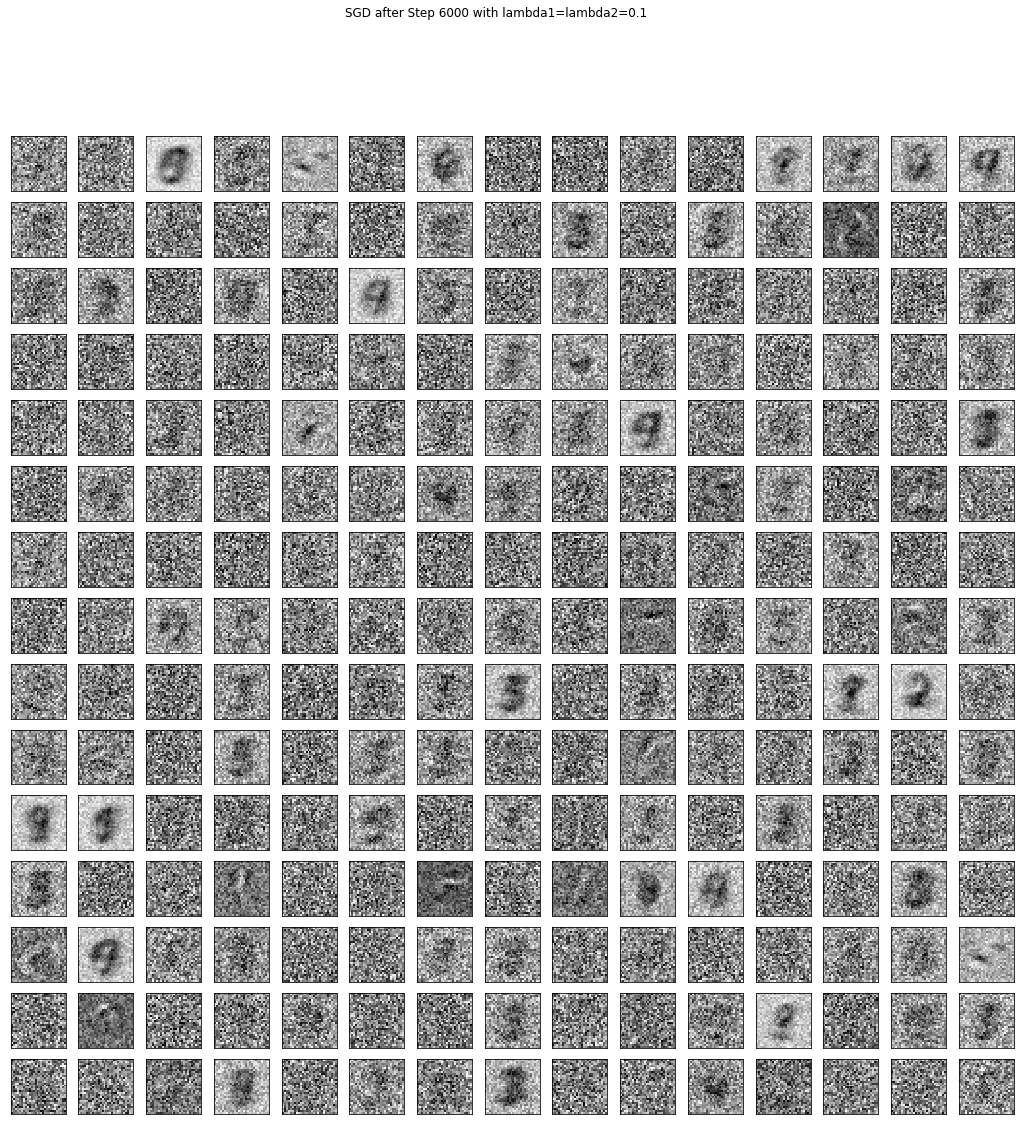

In [17]:
import matplotlib.pylab as pylab

num_steps = 6001
ll , atr, av = [], [], []

with tf.Session(graph=graph) as session:
    #tf.global_variables_initializer().run()
    session.run(tf.initialize_all_variables())
    print("Initialized")
    for step in range(num_steps):
        # offset으로 랜덤하게 학습 데이터 선택, epochs으로 더 나은 랜덤 배정 가능
        offset = (step * batch_size) % (y_train.shape[0] - batch_size)
        
        # 미니배치 생성
        batch_data = X_train[offset:(offset + batch_size), :]
        batch_labels = y_train[offset:(offset + batch_size), :]
        
        # 세션 실행에서 미니배치에 전할 딕셔너리 준비
        # 딕셔너리 키- 그래프의 플레이스홀더 노드
        # 딕셔너리 값- 플레이스홀더에 제공하는 numpy array
        feed_dict = {tf_train_dataset: batch_data, tf_train_labels: batch_labels}
        _, l, predictions = session.run([optimizer, loss, train_prediction], \
                                        feed_dict=feed_dict)
        
        if (step % 500 == 0):
            ll.append(l)
            a1 = accuracy(predictions, batch_labels)
            a2 = accuracy(valid_prediction.eval(), y_valid)
            atr.append(a1)
            av.append(a2)     
            
    images = weights1.eval()
    pylab.figure(figsize=(18,18))
    indices = np.random.choice(num_hidden_units, 225)
    
    for j, idx in enumerate(indices):
        pylab.subplot(15, 15, j + 1)
        pylab.imshow(np.reshape(images[:, idx], (image_size, image_size)), cmap='gray')
        pylab.xticks([],[]), pylab.yticks([],[])
        
    pylab.suptitle('SGD after Step ' + str(step) + ' with lambda1=lambda2=' + str(lambda1))
    pylab.show() 


In [ ]:
그래프 그리기

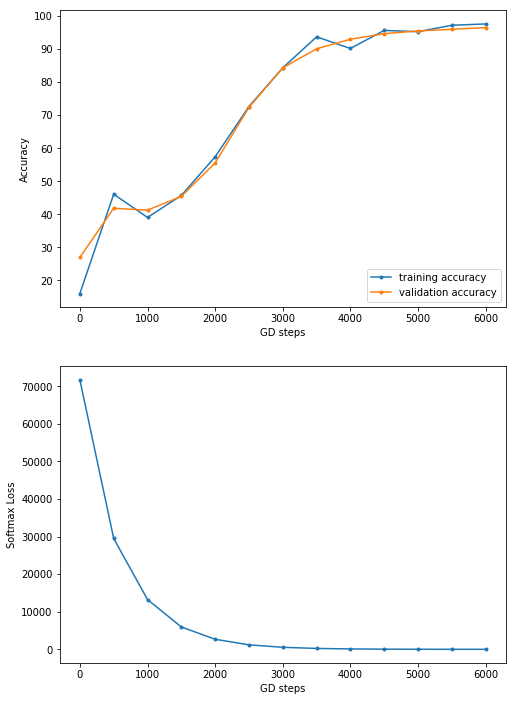

In [18]:
pylab.figure(figsize=(8, 12))
pylab.subplot(211)
pylab.plot(range(0, num_steps, 500), atr, '.-', label='training accuracy')
pylab.plot(range(0, num_steps, 500), av, '.-', label='validation accuracy')
pylab.xlabel('GD steps'), pylab.ylabel('Accuracy')
pylab.legend(loc='lower right')
pylab.subplot(212)
pylab.plot(range(0, num_steps, 500), ll, '.-')
pylab.xlabel('GD steps'), pylab.ylabel('Softmax Loss')
pylab.show()